# Setup


In [1]:
import os
import getpass

def _set_env(var: str):
  if not os.environ.get(var):
    os.environ[var] = getpass.getpass(f"Enter {var}: ")

os.environ["LANGSMITH_TRACING"] = "true"
os.environ["LANGSMITH_PROJECT"] = "metadata-harmonization"

In [2]:
_set_env("OPENAI_API_KEY")
_set_env("LANGSMITH_API_KEY")

In [3]:
%cd ../src
%load_ext autoreload
%autoreload 2

/Users/josefhardi/Documents/Code/assay-metadata-harmonization/src


# Tool Definition

In [ ]:
# Install additional required packages
%pip install langchain
%pip install langchain-openai
%pip install langchain-core
%pip install langgraph


In [ ]:
%pip install pydantic
%pip install jsonpatch

In [42]:
from pydantic import BaseModel
from typing import Dict, Any, List
from langchain_core.tools import tool
import jsonpatch
import copy

def apply_patch(document: Dict[str, Any], patches: List[Dict[str, Any]]) -> Dict[str, Any]:
  """
  Apply a JSON Patch to a JSON document.
  
  Args:
    document: The original JSON document to patch
    patch: A list of JSON Patch operations
  
  Returns:
    The patched JSON document
    
  Raises:
    jsonpatch.JsonPatchException: If the patch is invalid or cannot be applied
  """
  try:
    # Create a deep copy of the document to avoid modifying the original
    document_copy = copy.deepcopy(document)
    
    # Create a JsonPatch object from the patch list
    json_patch = jsonpatch.JsonPatch(patches)
    
    # Apply the patch to the document
    patched_document = json_patch.apply(document_copy)
    
    return patched_document
    
  except jsonpatch.JsonPatchException as e:
    raise ValueError(f"Failed to apply JSON patch: {str(e)}")
  except Exception as e:
    raise ValueError(f"Unexpected error while applying patch: {str(e)}")

@tool
class Done(BaseModel):
  """Task is done."""
  done: bool

## Triage Input Metadata

In [43]:
from assistant.states import AppState
from assistant.schemas import RNASEQ_SCHEMA
from typing import Literal
from langgraph.types import Command
from langgraph.graph import END

def triage_metadata(state: AppState) -> Command[Literal["agent_manager", END]]:
  """
  Triage metadata based on the dataset type in the input metadata.
  """
  # TODO: Add a check to see if the dataset type is in the list of supported dataset types
  dataset_type = state["document"].get("dataset_type")

  schema = None
  if dataset_type == "RNAseq":
    goto = "agent_manager"
    schema = RNASEQ_SCHEMA
  else:
    goto = END

  return Command(goto=goto, update={
    "schema": schema
  })


## Agent Manager

In [54]:
from assistant.states import AppState
from typing import Literal
from langgraph.types import Command
from langgraph.graph import END
from langchain.chat_models import init_chat_model

# Initialize the LLM
agent_manager_llm = init_chat_model("openai:gpt-4.1", temperature=0.0)

def agent_manager_llm_call(state: AppState) -> Command[Literal["data_analyst", END]]:
  """
  Agent to manage the metadata evolution process. This agent decides what to do with the metadata:
  - If patches are available, apply them to the input metadata and end the workflow.
  - If instructions and patches are not available, route to data_analyst to plan the instructions for updating the metadata.
  """
  input_metadata = state["document"].get('metadata')
  patches = state.get("patches", [])

  if len(patches) > 0:
    # Apply patches to the input metadata
    try:
      harmonized_metadata = apply_patch(input_metadata, patches)
      return Command(
          goto=END,
          update={
            "messages": [{
              "role": "assistant", 
              "content": f"Successfully applied {len(patches)} patches to update the metadata. Task completed."
            }]
          }
        )
    except Exception as e:
      return Command(
        goto=END,
        update={
          "messages": [{
            "role": "assistant",
            "content": f"Error applying patches: {str(e)}. Task failed."
          }]
        }
      )
  else:
    return Command(
      goto="data_analyst",
      update={
        "messages": [{
          "role": "user",
          "content": f"Process the metadata accordingly: \n\n{input_metadata}"
        }]
      }
    )

## Data Analyst

In [45]:
from assistant.states import AppState
from assistant.models import ChangeInstruction
from assistant.prompts import data_analyst_system_prompt

from typing import Literal
from langgraph.types import Command
from langchain.chat_models import init_chat_model

# Initialize the LLM with structured output
data_analyst_llm = init_chat_model("openai:gpt-4.1", temperature=0.0).with_structured_output(ChangeInstruction)

def data_analyst_llm_call(state: AppState) -> Command[Literal["programmer"]]:
  """
  Agent to analyze the metadata and target schema to create a list of instructions to update the metadata.
  """
  
  response = data_analyst_llm.invoke(
    # Add the system prompt
    [{ 
      "role": "system",
      "content": data_analyst_system_prompt.format(schema=state["schema"])
    }]
    # Add the current messages to the prompt
    + state["messages"]
  )
  
  # Extract instructions directly from the structured response
  instructions = response.instructions
  
  return Command(
    goto="programmer", 
    update={
      "messages": [{
        "role": "assistant", 
        "content": f"Created {len(instructions)} instructions for metadata harmonization."
      }],
      "instructions": instructions
    }
  )

## Programmer

In [46]:
from assistant.prompts import programmer_system_prompt, programmer_user_prompt
from assistant.states import AppState
from assistant.models import JsonPatch

from langchain.chat_models import init_chat_model

programmer_llm = init_chat_model("openai:gpt-4o", temperature=0.0).with_structured_output(JsonPatch)

def programmer_llm_call(state: AppState) -> Command[Literal["agent_manager"]]:
  """
  Create a JSON Patch object to update the metadata.

  Args:
    instructions: A list of instructions to create a JSON Patch object.

  Returns:
    A list of JSON Patch objects.
  """
  patches = []
  for instruction in state["instructions"]:
    user_prompt = programmer_user_prompt.format(instruction=instruction)
    patch = programmer_llm.invoke(
        [
          { "role": "system", "content": programmer_system_prompt },
          { "role": "user", "content": user_prompt }
        ]
    )
    patches.append(patch)

  return Command(
    goto="agent_manager", 
    update={
      "messages": [{
        "role": "assistant", 
        "content": f"Created {len(patches)} patches for updating themetadata."
      }],
      "patches": patches
    }
  )
    

# Usage

In [55]:
from langgraph.graph import StateGraph
from assistant.states import AppState

def create_metadata_updating_workflow():
  """
  Create the complete LangGraph workflow for updating the metadata.
  
  Flow: 
  1. triage_metadata -> agent_manager 
  2. agent_manager -> (if no patches) data_analyst -> programmer -> agent_manager
  3. agent_manager -> (if patches exist) apply patches -> END
  """
  
  # Create the StateGraph
  workflow = StateGraph(AppState)
  
  # Add nodes to the graph
  workflow.add_node("triage", triage_metadata)
  workflow.add_node("agent_manager", agent_manager_llm_call)  
  workflow.add_node("data_analyst", data_analyst_llm_call)
  workflow.add_node("programmer", programmer_llm_call)
  
  # Set the entry point
  workflow.set_entry_point("triage")
  
  # Compile the graph
  app = workflow.compile()
  
  return app

# Create the workflow
app = create_metadata_updating_workflow()

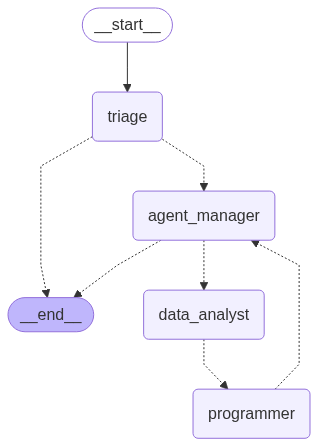

In [52]:
from assistant.utils import show_graph

show_graph(app)

## Dummy Example

In [56]:
example_document = {
    "uuid": "421007293469db7b528ce6478c00348d",
    "hubmap_id": "HBM575.XFCT.276",
    "status": "Published",
    "group_name": "University of California San Diego TMC",
    "dataset_type": "RNAseq",
    "metadata": {
      "acquisition_instrument_model": "NovaSeq",
      "acquisition_instrument_vendor": "Illumina",
      "analyte_class": "RNA",
      "assay_category": "sequence",
      "assay_type": "SNARE2-RNAseq",
      "cell_barcode_offset": "10,48,86",
      "cell_barcode_read": "R2",
      "cell_barcode_size": "8,8,8",
      "contributors_path": "extras/bukmap_20190822_contributors.tsv",
      "data_path": ".",
      "donor_id": "UCSD0006",
      "execution_datetime": "2019-08-22 11:00",
      "is_targeted": "False",
      "is_technical_replicate": "False",
      "library_adapter_sequence": "CTGTCTCTTATACACATCT",
      "library_average_fragment_size": "700",
      "library_construction_protocols_io_doi": "10.17504/protocols.io.be5gjg3w",
      "library_final_yield_unit": "ng",
      "library_final_yield_value": "673",
      "library_id": "KM47",
      "library_layout": "paired-end",
      "library_pcr_cycles": "19",
      "library_pcr_cycles_for_sample_index": "12",
      "operator": "Nongluk Plongthongkum",
      "operator_email": "nplongth@eng.ucsd.edu",
      "pi": "Kun Zhang",
      "pi_email": "kzhang@eng.ucsd.edu",
      "protocols_io_doi": "10.17504/protocols.io.be5gjg3w",
      "rnaseq_assay_input": "16000",
      "rnaseq_assay_method": "SNARE-Seq2-RNA",
      "sc_isolation_cell_number": "4420000",
      "sc_isolation_enrichment": "FACS",
      "sc_isolation_entity": "nucleus",
      "sc_isolation_protocols_io_doi": "10.17504/protocols.io.ufketkw",
      "sc_isolation_quality_metric": "OK",
      "sc_isolation_tissue_dissociation": "dounce",
      "sequencing_phix_percent": "20",
      "sequencing_read_format": "70/6/104",
      "sequencing_read_percent_q30": "94.07",
      "sequencing_reagent_kit": "NovaSeq 6000 S4 Reagent",
      "tissue_id": "UCSD0006-RK-1-1-1"
    }
  }

app.invoke({"document": example_document})

{'messages': [HumanMessage(content="Process the metadata accordingly: \n\n{'acquisition_instrument_model': 'NovaSeq', 'acquisition_instrument_vendor': 'Illumina', 'analyte_class': 'RNA', 'assay_category': 'sequence', 'assay_type': 'SNARE2-RNAseq', 'cell_barcode_offset': '10,48,86', 'cell_barcode_read': 'R2', 'cell_barcode_size': '8,8,8', 'contributors_path': 'extras/bukmap_20190822_contributors.tsv', 'data_path': '.', 'donor_id': 'UCSD0006', 'execution_datetime': '2019-08-22 11:00', 'is_targeted': 'False', 'is_technical_replicate': 'False', 'library_adapter_sequence': 'CTGTCTCTTATACACATCT', 'library_average_fragment_size': '700', 'library_construction_protocols_io_doi': '10.17504/protocols.io.be5gjg3w', 'library_final_yield_unit': 'ng', 'library_final_yield_value': '673', 'library_id': 'KM47', 'library_layout': 'paired-end', 'library_pcr_cycles': '19', 'library_pcr_cycles_for_sample_index': '12', 'operator': 'Nongluk Plongthongkum', 'operator_email': 'nplongth@eng.ucsd.edu', 'pi': 'Kun